In [11]:
import pandas as pd
import numpy as np
import re


# For data viz
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# File system manangement
import os

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

pd.set_option('plotting.backend', 'plotly')
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)

# Model interpretation

## Utils

In [2]:
from preprocess_utils import encoding, handle_nans, scaling, sample_data
from classification_utils import *

from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KDTree
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split

# Models used
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Evaluating our models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer


def handle_outliers(df):
    ### DAYS_EMPLOYED_ANOM ###
    # Create an anomalous flag column
    df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
    # Replace the anomalous values with nan
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    df.DAYS_EMPLOYED = df.DAYS_EMPLOYED.abs()
    print(f'(DAYS_EMPLOYED) {df["DAYS_EMPLOYED_ANOM"].sum()} anomalous values found.')

    ### DAYS columns ###
    for col in df.columns[df.columns.str.contains('DAYS')]:
        df[col] = df[col].abs()

    ### Categorical XNA ###
    for col_name in df.select_dtypes(include='object').columns:
        if 'XNA' in (df[col_name].unique()):
            nb_xna = df[col_name].value_counts().loc['XNA']
            print(f'{nb_xna} XNAs found in {col_name}')
            df[col_name].replace('XNA', np.nan, inplace=True)

    return df

def train_model(X_train, y_train, model, grid, scoring='roc_auc'):
    model_cv = GridSearchCV(model, grid, cv=5, scoring=scoring, verbose=2, error_score='raise', n_jobs=-1)

    # Train on the training data
    model_cv.fit(X_train, y_train)
    
    return model_cv

def business_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0] ; tp = cm[1,1] 
    fn = cm[1,0] ; fp = cm[0,1]

    if type(y_true) == np.ndarray:
        max_score = np.unique(y_true, return_counts=True)[1][0]*2 + np.unique(y_true, return_counts=True)[1][0]*1
    else:
        max_score = np.unique(y_true.values, return_counts=True)[1][0]*2 + np.unique(y_true.values, return_counts=True)[1][0]*1


    score = (tn*2 + tp*1 + fp*(-2) + fn*(-20) )
    
    return score

business_scoring = make_scorer(business_score, greater_is_better=True)


def classif_score(y_true, X_test, model, name_model, display_cm = True):
    
    y_pred = model.predict(X_test).astype('int')
    
    if display_cm:
        cm = confusion_matrix(y_true, y_pred)
        make_confusion_matrix(cm, sum_stats=False, cbar=False, figsize=(4,4), title='Confusion Matrix')

    data = {'Accuracy': round(accuracy_score(y_true, y_pred), 3),
          'AUROC': round(roc_auc_score(y_true, model.predict_proba(X_test)[:,1]), 3),
          'Precision': round(precision_score(y_true, y_pred), 3),
          'Recall': round(recall_score(y_true, y_pred), 3),
          'F1-Score': round(f1_score(y_true, y_pred), 3),
          'FBeta-Score': round(fbeta_score(y_true, y_pred, beta=3, average='binary'), 3), # Report only for the positive label
          'Business_score': round(business_score(y_true, y_pred) ,3)
        }
    return pd.DataFrame(data, index=[name_model])

def adding_features(df, target):
    age = df.DAYS_BIRTH/365
    
    # AMT_CREDIT: Credit amount of the loan ; AMT_ANNUITY: Loan annuity
    credit_annuity_ratio = df.AMT_CREDIT /  df.AMT_ANNUITY
    credit_goods_price_ratio =  df.AMT_CREDIT / df.AMT_GOODS_PRICE
    credit_income_ratio =  df.AMT_CREDIT / df.AMT_INCOME_TOTAL
    annuity_income_ratio = df.AMT_ANNUITY / df.AMT_INCOME_TOTAL
    days_employed_life = df.DAYS_EMPLOYED / df.DAYS_BIRTH
    
    
    tmp = df[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']]
    tmp = pd.concat([tmp, credit_annuity_ratio.rename('CREDIT_ANNUITY_RATIO')], axis=1) 
    
#     # Computing Nearest Neigbors
#     scaler = MinMaxScaler()
#     scaled = scaler.fit_transform(tmp)
    
#     kdt = KDTree(scaled)
    
#     mean_target_50_nn = []

#     for index, row in enumerate(scaled):
#         indices = kdt.query(row.reshape(1,-1), 50, return_distance = False) # Compute the 50 nearest neighbors of a given line
#         if target.iloc[indices[0]].mean() >= 0.5: # Determine the mean of the target of the 500nearest neighbors
#             mean_target_50_nn.append(1)
#         else: 
#             mean_target_50_nn.append(0)
            
    # Adding new features to the dataframe
    df['AGE'] = age
    df['CREDIT_ANNUITY_RATIO'] = credit_annuity_ratio
    df['CREDIT_GOODS_PRICE_RATIO'] = credit_goods_price_ratio
    df['CREDIT_INCOME_RATIO'] = credit_income_ratio
    df['ANNUITY_INCOME_RATIO'] = annuity_income_ratio
    df['DAYS_EMPLOYED_LIFE'] = days_employed_life
    
#     df['TARGET_50_NN'] = mean_target_50_nn
    
    print('Features added.')
    
    return df

def delete_correl_features(df, to_drop):
    return df.drop(to_drop, axis=1)

def delete_low_var(X_train, X_test, var_th=0.01):  
    selector = VarianceThreshold(threshold=var_th)
    selector.fit(X_train)
    col_to_drop = X_train.columns[~selector.get_support()] # Easier to debug
    print(f'With var_th={var_th}: {len(col_to_drop)} columns dropped.')
    X_train = X_train.drop(col_to_drop, axis=1)
    X_test = X_test.drop(col_to_drop, axis=1)
    
    return X_train, X_test, col_to_drop

from sklearn.feature_selection import SelectFromModel

def delete_from_model(X_train, y_train, X_test, threshold_from_model='mean'):
    selector = SelectFromModel(DecisionTreeClassifier(random_state=42), threshold=threshold_from_model)
    selector.fit(X_train, y_train)
    
    col_to_drop = X_train.columns[~selector.get_support()] # Easier to debug
    print(f'With threshold={threshold_from_model}: {len(col_to_drop)} columns dropped.')
    X_train = X_train.drop(col_to_drop, axis=1)
    X_test = X_test.drop(col_to_drop, axis=1)
    
    return X_train, X_test, col_to_drop

In [3]:
def preprocessing_fe(data, delete_correl = False, adding_f = False, low_var = False, var_th = 0.01, from_model=False, s=MinMaxScaler, return_object_to_ser=False, **params_scaler):
    df = data.copy(deep=True)
    
    col_to_drop = []
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # Delete special JSON characters from column names
    if delete_correl:
        to_drop = ['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'REGION_RATING_CLIENT_W_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE',
              'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE',
               'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LANDAREA_AVG', 'LANDAREA_MODE', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG', 
               'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'FLAG_EMP_PHONE'
              ]
        col_to_drop.append(to_drop)
        df = delete_correl_features(df, to_drop)

    print("Handling Outliers".center(50, '-'))
    df = handle_outliers(df)
    print()

    print("Encoding".center(50, '-'))
    df, col_to_le, enc = encoding(df) # TARGET will not be treated as categorical variables here
    print()  

    print('Splitting in train/test set'.center(50, '-'))
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['TARGET'])
    X_train = train.drop('TARGET', axis=1);   y_train = train.TARGET
    X_test = test.drop('TARGET', axis=1);  y_test = test.TARGET
    print('train:', X_train.shape);  print('test:', X_test.shape)
    print()
    
    print("Handling NaNs".center(50, '-'))
    print('train: ', end=' '); X_train, imputer = handle_nans(X_train)
    print('test: ', end=' '); print(f'{X_test.isna().sum().sum()} nans found.')
    col_num = X_test.select_dtypes(include=np.number).columns
    X_test[col_num] = imputer.transform(X_test[col_num])
    print()
    
    if adding_f:
        print("Adding Features".center(50, '-'))
        print('train:', end=' '); X_train = adding_features(X_train, y_train)
        print('test: ', end=' '); X_test = adding_features(X_test, y_test)
        print()
        
    if low_var:
        print("Deleting low variance features".center(50, '-'))
        X_train, X_test, to_drop = delete_low_var(X_train, X_test, var_th)
        col_to_drop.append(to_drop)
        print()
        
        
    if from_model:
        print("Deleting with model features importance".center(50, '-'))
        X_train, X_test, to_drop = delete_from_model(X_train, y_train, X_test, threshold_from_model='mean')
        col_to_drop.append(to_drop)
        print()

    print("Scaling".center(50, '-'))
    X_train, X_test, scaler = scaling(X_train, X_test, s=s,  **params_scaler)
    print()    
    

    if return_object_to_ser:
        to_serialize = {'scaler': scaler, 'imputer': imputer,
                  'le':col_to_le, 'one_hot': enc, 
                  'to_drop': to_drop.append(col_to_drop)}
        return X_train, y_train, X_test, y_test, to_serialize
    else:
        return X_train, y_train, X_test, y_test

## Loading datas

In [4]:
import shap
import pickle, sys
from preprocess_utils import sample_data

In [5]:
print(sys.version)

3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]


In [6]:
path_rf = './rf_objects/'

best_model = pickle.load(open(path_rf+'rf_best', 'rb'))
scaler_rf = pickle.load(open(path_rf+'scaler_rf', 'rb'))
imputer_rf = pickle.load(open(path_rf+'imputer_rf', 'rb'))
le_rf = pickle.load(open(path_rf+'le_rf', 'rb'))
one_hot_rf = pickle.load(open(path_rf+'one_hot_rf', 'rb'))
to_drop = pickle.load(open(path_rf+'to_drop', 'rb'))

y_test_rf = pickle.load(open(path_rf+'y_test_rf', 'rb'))
X_test_rf = pickle.load(open(path_rf+'X_test_rf', 'rb'))

In [7]:
path = './application_train.csv'

df = pd.read_csv(path)

In [21]:
X_train, y_train, _, _ = preprocessing_fe(df, delete_correl=False, adding_f=True, low_var=True, 
                                                                    var_th=0.01, return_object_to_ser=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

----------Deleting low variance features----------
With var_th=0.01: 125 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}



In [8]:
sample_test, _ = sample_data(X_test_rf, y_test_rf, nb_samples=10)
# sample_train, _ = sample_data(X_train, y_train, nb_samples=10000)

(10, 122)
(10,)
0    0.9
1    0.1
Name: TARGET, dtype: float64


In [ ]:
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(sample_train)

### Global interpretation

What features have the most impact on the parameters of my model ?

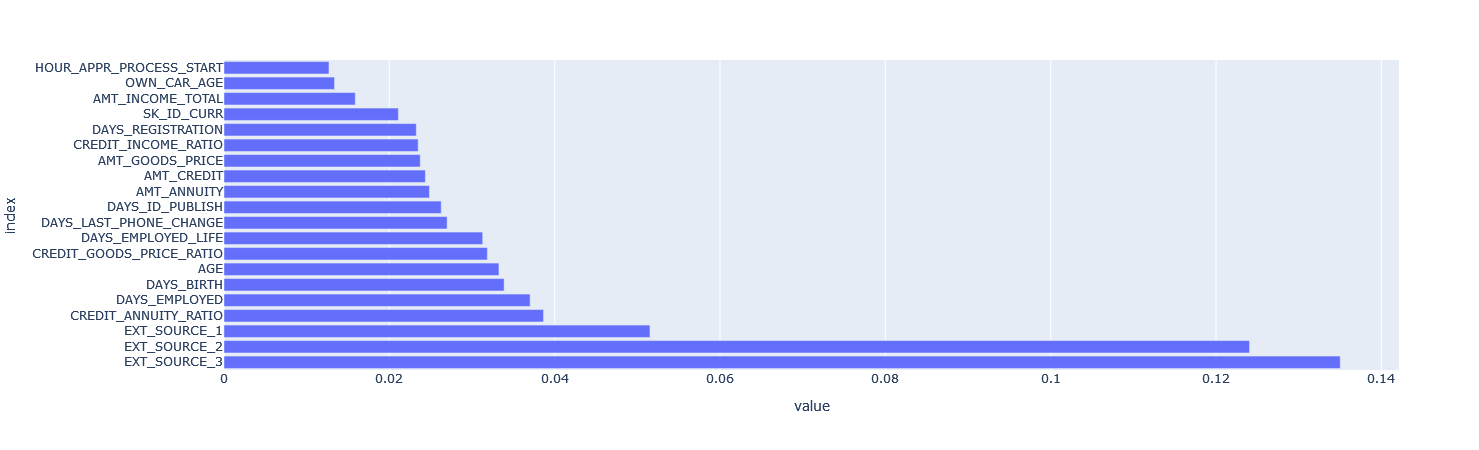

In [15]:
feat_importances = pd.Series(best_model.feature_importances_, index=best_model.feature_names_in_)
fig = feat_importances.nlargest(20).plot(kind='barh')
fig.update_layout(showlegend=False)
fig.show()

### Local interpretation

Here we try with a single client

In [18]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(sample_test)

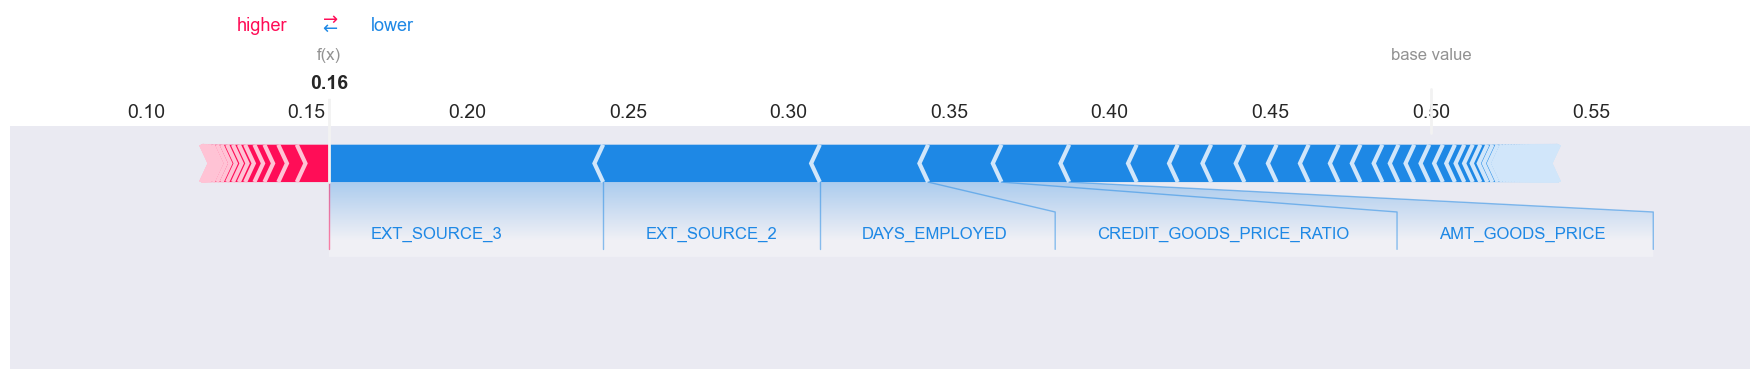

In [26]:
# shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=sample_test.columns, matplotlib=True)
plt.show()

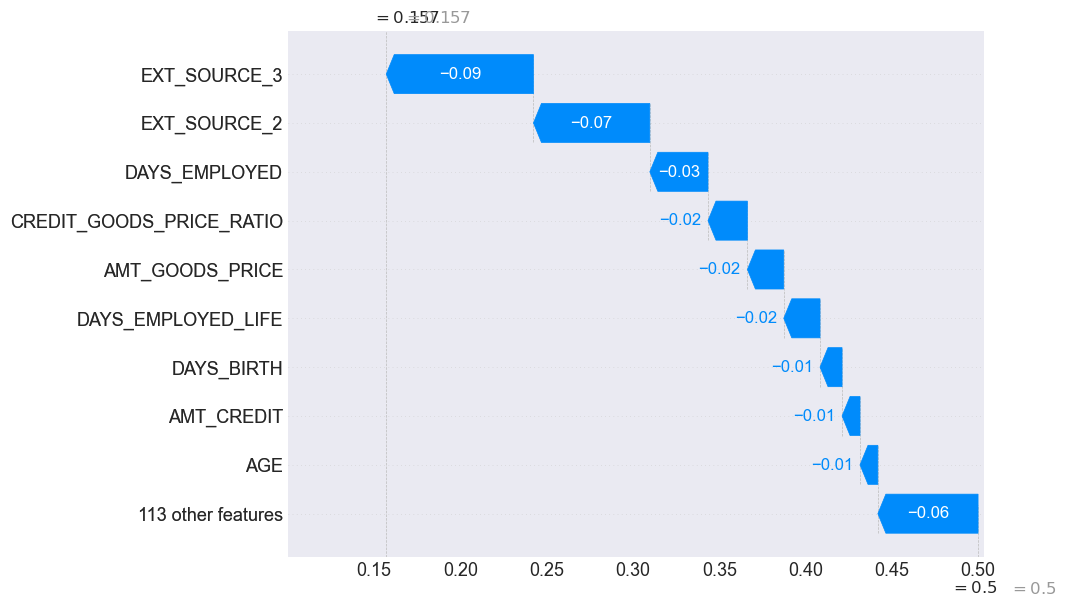

In [28]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0], feature_names=sample_test.columns)